In [1]:
%matplotlib inline

import pandas as pd
import os
import os.path as op

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math

wd = "/mnt/scgc/simon/simonsproject/gorg-tara_clustering/"
os.chdir(wd)

Calculate the length of the seed sequences for all GORG-TARA clusters identified in mmseqs2 analysis (see Figure 3A notebook for mmseqs2 analysis parameters).  Seed sequences found in mmseqs2 output file with \*.faa suffix

Then ran below script overnight:

```
import itertools

def readfa(fh):
    for header, group in itertools.groupby(fh, lambda line: line[0] == '>'):
        if header:
            line = next(group)
            name = line[1:].strip()
        else:
            seq = ''.join(line.strip() for line in group)
            yield name, seq


filename = "analyses/gorg_tara_tropics_80minid_m80_sizes.csv"
fasta = "analyses/gorg_tara_tropics_80minid_m80.faa"

with open(filename, "w") as oh:
    for name, seq in readfa(open(fasta)):
        print(name, len(seq), file=oh, sep=",")
```

Load table used in generation of figure 3A

In [2]:
scp = pd.read_csv("analyses/gorg_tara_tropics_80minid_kmer80_counts_by_source.csv")[['c1','TARA','gorg']]

Load seed size table generated with above script

In [3]:
sizedf = pd.read_csv("analyses/gorg_tara_tropics_80minid_m80_sizes.csv", names = ['orf','aa_count'])

Add total column for cluster size (number of sequences in cluster) and combine tables

In [4]:
scp['total'] = scp['gorg'] + scp['TARA']
scp = scp.merge(sizedf, left_on = 'c1', right_on='orf')

In [5]:
scp.head()

,c1,TARA,gorg,total,orf,aa_count
0,TARA_004_DCM_0.22-1.6_C22365543_1_gene422493,1.0,0.0,1.0,TARA_004_DCM_0.22-1.6_C22365543_1_gene422493,166
1,TARA_004_DCM_0.22-1.6_C22365545_1_gene422494,1.0,0.0,1.0,TARA_004_DCM_0.22-1.6_C22365545_1_gene422494,50
2,TARA_004_DCM_0.22-1.6_C22365547_1_gene422497,1.0,0.0,1.0,TARA_004_DCM_0.22-1.6_C22365547_1_gene422497,39
3,TARA_004_DCM_0.22-1.6_C22365549_1_gene422498,1.0,0.0,1.0,TARA_004_DCM_0.22-1.6_C22365549_1_gene422498,26
4,TARA_004_DCM_0.22-1.6_C22365551_1_gene422500,1.0,0.0,1.0,TARA_004_DCM_0.22-1.6_C22365551_1_gene422500,166


In [6]:
binsplits = [0,1, 10, 100, 1000, 5000, 12000]
scp['bin'] = pd.cut(scp['total'], bins=binsplits)

# add column for bin labels
ncd = dict(zip(list(scp['bin'].drop_duplicates()), ['1', '2-10','11-100','101-1000', '1001-5000','5001-12000']))
scp['bin_label'] = [ncd[i] for i in scp['bin']]

# take log of aa_count
scp['log_aa'] = [math.log(i, 10) for i in scp['aa_count']]

Exploring seed size by bin size

/mnt/scgc_nfs/opt/common/anaconda3/4.0.0/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/mnt/scgc_nfs/opt/common/anaconda3/4.0.0/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


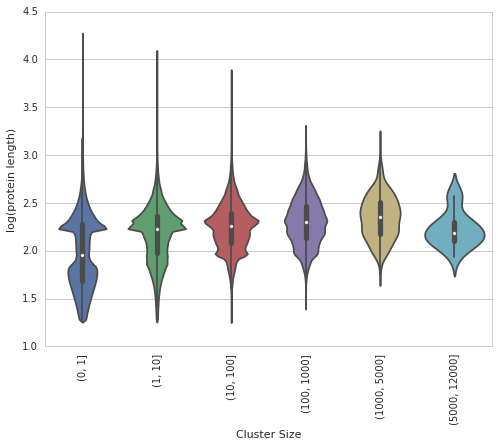

In [9]:
fig = plt.figure(figsize=(8,6))

sns.violinplot(x='bin', y='log_aa', data=scp)
plt.xticks(rotation=90)
plt.xlabel('Cluster Size')
plt.ylabel('log(protein length)')

Compare the size distribution of singletons to bins with more than 10 members.

In [7]:
bin1 = list(scp[scp['total'] == 1]['log_aa'])
bingt10 = list(scp[scp['total'] > 10]['log_aa'])

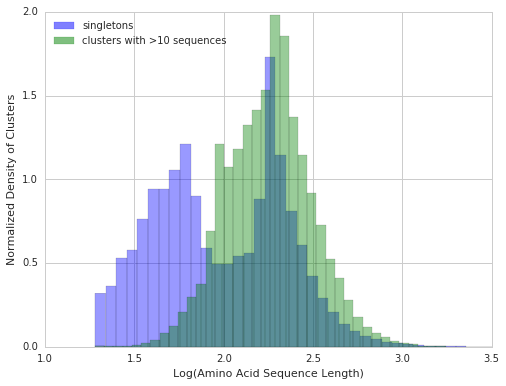

In [8]:
cdict = {'singletons':'blue','clusters with >10 sequences':'green'}
fig = plt.figure(figsize=(8,6))
sns.set_style('whitegrid')

sns.distplot(bin1, kde=False, norm_hist=True, color="blue")
sns.distplot(bingt10, kde=False, norm_hist=True, color = "green")
plt.xlim(1,3.5)

legend_elements = [Patch(facecolor=cdict[i], edgecolor=cdict[i], alpha=0.5, label=i) for i in cdict]
plt.legend(handles=legend_elements, loc=2,
          fancybox=False, shadow=False, frameon=False, ncol=1)

plt.xlabel('Log(Amino Acid Sequence Length)')

plt.ylabel('Normalized Density of Clusters')